In [36]:
##################################################################
# This Script:
#    - 
#    -
#    -

##################################################################
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "1980_2001"
yrs= range(1981,2002)
resolution = '2.2km' #2.2km, 12km, 2.2km_regridded_12km

In [2]:
em = '01'

In [3]:
ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/leeds-at-centre/{em}/"

print(em, resolution, trim_to_leeds)

yr = 1990

01 2.2km False


In [102]:
# ### Get a list of filenames for this ensemble member, for just JJA
if resolution == '2.2km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
elif resolution == '12km':
      general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
elif resolution == '2.2km_regridded_12km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_*'

filenames = []
for filename in sir_globington_the_file_gatherer.glob(general_filename):
    filenames.append(filename)
print(f"loading {len(filenames)} files")

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]

# ### Concatenate cubes into one
model_cube = monthly_cubes_list.concatenate_cube()      

### Remove ensemble member dimension
model_cube = model_cube[0,:,:,:]

loading 3 files


### Get the mask

In [38]:
print("getting mask")
gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

getting mask


### Apply the mask - v1.

In [103]:
# # Reshape the mask array to match the shape of the cube
# reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
# i=np.where(reshaped_mask == 0)
# model_cube.data[i]=np.nan

### Apply the mask - v2.

In [45]:
# model_cube_data = model_cube.data * reshaped_mask
# model_cube.data = model_cube_data

In [104]:
# # Reshape the mask array to match the shape of the cube
reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
reshaped_mask = reshaped_mask.astype(int)
reversed_array = ~reshaped_mask.astype(bool)

In [105]:
masked_cube = iris.util.mask_cube(model_cube, reversed_array)

### Check the mask

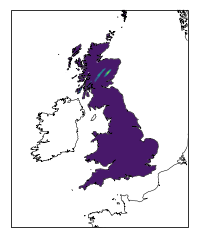

In [106]:
iplt.contourf(masked_cube[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

### Trim to UK

In [112]:
masked_cube = trim_to_bbox_of_region_regriddedobs(masked_cube, gb_gdf)

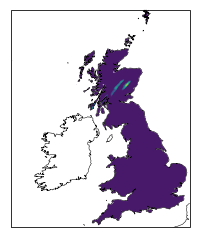

In [113]:
iplt.contourf(masked_cube[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [114]:
# Get rid of negative values
compressed = masked_cube.data.compressed()
compressed.shape[0]

100293120

In [115]:
########
# Get the times
########
# Step 2: Get the indices of the non-masked values in the original data
non_masked_indices = np.where(~masked_cube.data.mask)

# Step 3: Extract corresponding time values
time_values = masked_cube.coord('time').points[non_masked_indices[0]]
np.save(ddir + f'timevalues_{yr}.npy', time_values) 
time_values.shape
np.save(ddir + f'compressed_{yr}.npy', compressed) 

(100293120,)

In [117]:
ddir

'ProcessedData/TimeSeries/UKCP18_hourly/2.2km/1980_2001/leeds-at-centre/01/'